In [1]:
#@title Cargar librerias y funciones { display-mode: "form" }
#@markdown Se recomienda correr el entorno de ejecución en GPU
from glob import glob
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn import datasets
import tensorflow as tf
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
print(tf.__version__)

def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img.reshape(299, 299,3).astype('uint8'), cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

2.8.2


In [2]:
#@title Descarga de data-set { display-mode: "form" }
#@markdown Obtenemos nuestro data set sobre clasificación de imagenes distiguidas por la caracteristica presencia de hemorragia cerebral

! git clone https://github.com/NeiderSmith/gb_vs_nogb.git data_set
! ls

Cloning into 'data_set'...
remote: Enumerating objects: 1882, done.
remote: Counting objects: 100% (409/409), done.
remote: Compressing objects: 100% (407/407), done.
remote: Total 1882 (delta 8), reused 400 (delta 2), pack-reused 1473
Receiving objects: 100% (1882/1882), 1.05 GiB | 38.03 MiB/s, done.
Resolving deltas: 100% (11/11), done.
Checking out files: 100% (1895/1895), done.
data_set  sample_data


In [5]:
#@title Lectura de labels { display-mode: "form" }
#@markdown Obtenemos los labels de los data-sets que seran usados

df = pd.read_csv('data_set/labels_gb_vs_no_gb.csv', sep=";")
df.head()

df2 = pd.read_csv('data_set/labels_gb_emab_vs_no_gb.csv', sep=";")
df2.head()

path  label
0    gb_emab/img (1).jpeg      1
1     gb_emab/img (1).jpg      1
2   gb_emab/img (10).jpeg      1
3    gb_emab/img (10).jpg      1
4  gb_emab/img (100).jpeg      1

# Modelo 1 usando CNN y transferencia de aprendizaje (Data-set Kaggle)

## Procesamiento de datos

In [6]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(df['path'], df['label'], test_size=0.2)

train_imgs = []
for i in x_train_split:
  try:
    im = tf.keras.preprocessing.image.load_img('data_set/'+i, target_size=(299, 299))
    train_imgs.append(tf.keras.preprocessing.image.img_to_array(im));
  except AttributeError:
    print('rading an image')

test_imgs = []
for i in x_test_split:
  try:
    im = tf.keras.preprocessing.image.load_img('data_set/'+i, target_size=(299, 299))
    test_imgs.append(tf.keras.preprocessing.image.img_to_array(im));
  except AttributeError:
    print('rading an image')

x_train = np.array(train_imgs)
x_test = np.array(test_imgs)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
len(train_imgs), len(test_imgs), x_train.shape, x_test.shape

(1189, 298, (1189, 299, 299, 3), (298, 299, 299, 3))

In [7]:
y_test = tf.keras.utils.to_categorical(y_test_split)
y_train = tf.keras.utils.to_categorical(y_train_split) 

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0], "y_train:", y_train.shape)
print('Number of images in x_test', x_test.shape[0], "y_test: ", y_test.shape)

x_train shape: (1189, 299, 299, 3)
Number of images in x_train 1189 y_train: (1189, 2)
Number of images in x_test 298 y_test:  (298, 2)


## Creación y compilación del modelo

In [8]:
model_base =  tf.keras.applications.ResNet50V2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)

94683136/94668760 [==============================] - 0s 0us/step


In [9]:
model = tf.keras.Sequential([
  model_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 10, 10, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


## Entrenamiento

In [10]:
results = model.fit(x_train, y_train, epochs=20,verbose=1, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
38/38 [==============================] - 45s 623ms/step - loss: 0.6305 - accuracy: 0.6930 - val_loss: 0.4811 - val_accuracy: 0.8188
Epoch 2/20
38/38 [==============================] - 19s 499ms/step - loss: 0.3815 - accuracy: 0.9235 - val_loss: 0.3453 - val_accuracy: 0.8993
Epoch 3/20
38/38 [==============================] - 19s 507ms/step - loss: 0.2677 - accuracy: 0.9445 - val_loss: 0.2689 - val_accuracy: 0.9295
Epoch 4/20
38/38 [==============================] - 19s 511ms/step - loss: 0.1944 - accuracy: 0.9714 - val_loss: 0.2200 - val_accuracy: 0.9497
Epoch 5/20
38/38 [==============================] - 20s 522ms/step - loss: 0.1467 - accuracy: 0.9807 - val_loss: 0.1923 - val_accuracy: 0.9530
Epoch 6/20
38/38 [==============================] - 20s 521ms/step - loss: 0.1072 - accuracy: 0.9907 - val_loss: 0.1690 - val_accuracy: 0.9497
Epoch 7/20
38/38 [==============================] - 21s 549ms/step - loss: 0.0828 - accuracy: 0.9916 - val_loss: 0.1568 - val_accuracy: 0.9631

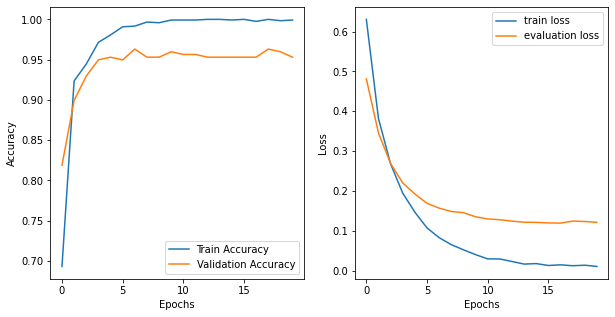

In [11]:
#@title Resultados del entrenamiento

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(results.history['accuracy'], label='Train Accuracy');
ax.plot(results.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(results.history['loss'], label='train loss');
ax.plot(results.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

(6, 299, 299, 3)
[[1.9982255e-10 1.0000000e+00]
 [1.5514857e-07 9.9999988e-01]
 [3.7498877e-04 9.9962497e-01]
 [6.1338454e-01 3.8661548e-01]
 [2.5230509e-01 7.4769491e-01]
 [5.6117153e-01 4.3882847e-01]]
(6, 2) [1 1 1 0 1 0]


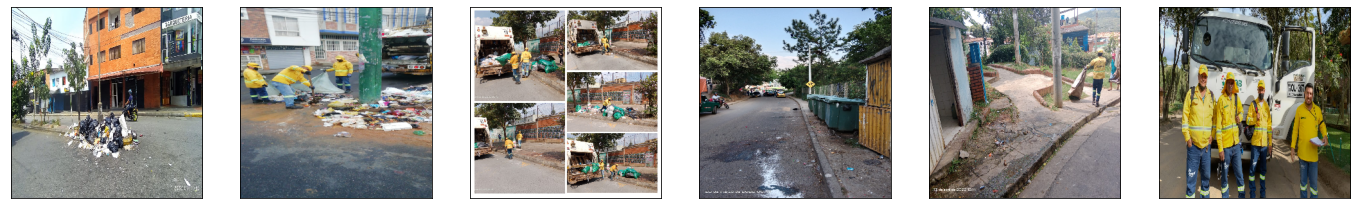

In [13]:
#@title **code** predict image classes
test = []
process1 = tf.keras.preprocessing.image.load_img("trash.jpeg", target_size=(299, 299))
process2 = tf.keras.preprocessing.image.load_img("trash2.jpeg", target_size=(299, 299))
process3 = tf.keras.preprocessing.image.load_img("trash3.jpeg", target_size=(299, 299))
process4 = tf.keras.preprocessing.image.load_img("no_trash.jpg", target_size=(299, 299))
process5 = tf.keras.preprocessing.image.load_img("no_trash2.jpg", target_size=(299, 299))
process6 = tf.keras.preprocessing.image.load_img("no_trash3.jpg", target_size=(299, 299))
test.append(tf.keras.preprocessing.image.img_to_array(process1));
test.append(tf.keras.preprocessing.image.img_to_array(process2));
test.append(tf.keras.preprocessing.image.img_to_array(process3));
test.append(tf.keras.preprocessing.image.img_to_array(process4));
test.append(tf.keras.preprocessing.image.img_to_array(process5));
test.append(tf.keras.preprocessing.image.img_to_array(process6));

trash = np.array(test)
trash = trash.astype('float32')
trash /= 255

print(trash.shape)
predictions = model.predict(trash)
fig = plt.figure(figsize=(24,24))
for i in range(6):
  ax = fig.add_subplot(1, 6, i+1)
  plot_image(i, predictions, np.argmax(y_test ,axis=1), test)
print(predictions)
print(predictions.shape, np.argmax(predictions, axis=1))

# Modelo 1 usando CNN y transferencia de aprendizaje (Data-set EMAB)

## Procesamiento de datos

In [14]:
x_train_split, x_test_split, y_train_split, y_test_split = train_test_split(df2['path'], df2['label'], test_size=0.2)

train_imgs = []
for i in x_train_split:
  try:
    im = tf.keras.preprocessing.image.load_img('data_set/'+i, target_size=(299, 299))
    train_imgs.append(tf.keras.preprocessing.image.img_to_array(im));
  except AttributeError:
    print('rading an image')

test_imgs = []
for i in x_test_split:
  try:
    im = tf.keras.preprocessing.image.load_img('data_set/'+i, target_size=(299, 299))
    test_imgs.append(tf.keras.preprocessing.image.img_to_array(im));
  except AttributeError:
    print('rading an image')

x_train = np.array(train_imgs)
x_test = np.array(test_imgs)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255
len(train_imgs), len(test_imgs), x_train.shape, x_test.shape

(928, 233, (928, 299, 299, 3), (233, 299, 299, 3))

In [15]:
y_test = tf.keras.utils.to_categorical(y_test_split)
y_train = tf.keras.utils.to_categorical(y_train_split) 

print('x_train shape:', x_train.shape)
print('Number of images in x_train', x_train.shape[0], "y_train:", y_train.shape)
print('Number of images in x_test', x_test.shape[0], "y_test: ", y_test.shape)

x_train shape: (928, 299, 299, 3)
Number of images in x_train 928 y_train: (928, 2)
Number of images in x_test 233 y_test:  (233, 2)


## Creación y compilación del modelo

In [16]:
model_base =  tf.keras.applications.ResNet50V2(input_shape=x_train[0].shape, weights='imagenet', include_top=False)

In [17]:
model2 = tf.keras.Sequential([
  model_base,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 10, 10, 2048)      23564800  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 2)                 4098      
                                                                 
Total params: 23,568,898
Trainable params: 23,523,458
Non-trainable params: 45,440
_________________________________________________________________


## Entrenamiento

In [18]:
results2 = model2.fit(x_train, y_train, epochs=20,verbose=1, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/20
29/29 [==============================] - 22s 580ms/step - loss: 0.6610 - accuracy: 0.6444 - val_loss: 0.5615 - val_accuracy: 0.7082
Epoch 2/20
29/29 [==============================] - 15s 515ms/step - loss: 0.4372 - accuracy: 0.8922 - val_loss: 0.4013 - val_accuracy: 0.8670
Epoch 3/20
29/29 [==============================] - 15s 535ms/step - loss: 0.2996 - accuracy: 0.9634 - val_loss: 0.2858 - val_accuracy: 0.9356
Epoch 4/20
29/29 [==============================] - 15s 524ms/step - loss: 0.2153 - accuracy: 0.9828 - val_loss: 0.2109 - val_accuracy: 0.9614
Epoch 5/20
29/29 [==============================] - 15s 527ms/step - loss: 0.1481 - accuracy: 0.9946 - val_loss: 0.1635 - val_accuracy: 0.9657
Epoch 6/20
29/29 [==============================] - 15s 536ms/step - loss: 0.1081 - accuracy: 0.9989 - val_loss: 0.1285 - val_accuracy: 0.9700
Epoch 7/20
29/29 [==============================] - 15s 533ms/step - loss: 0.0771 - accuracy: 0.9989 - val_loss: 0.1025 - val_accuracy: 0.9742

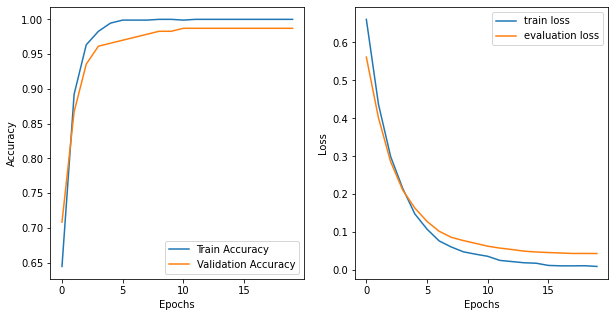

In [19]:
#@title Resultados del entrenamiento

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(results2.history['accuracy'], label='Train Accuracy');
ax.plot(results2.history['val_accuracy'], label='Validation Accuracy');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(results2.history['loss'], label='train loss');
ax.plot(results2.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

# Comparación de resultados

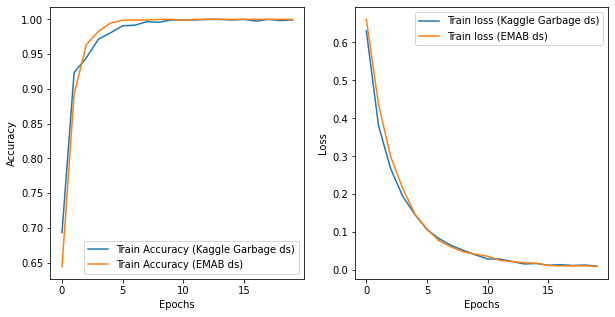

In [21]:
#@title Resultados del entrenamiento (Datos de entrenamiento)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(results.history['accuracy'], label='Train Accuracy (Kaggle Garbage ds)');
ax.plot(results2.history['accuracy'], label='Train Accuracy (EMAB ds)');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(results.history['loss'], label='Train loss (Kaggle Garbage ds)');
ax.plot(results2.history['loss'], label='Train loss (EMAB ds)');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

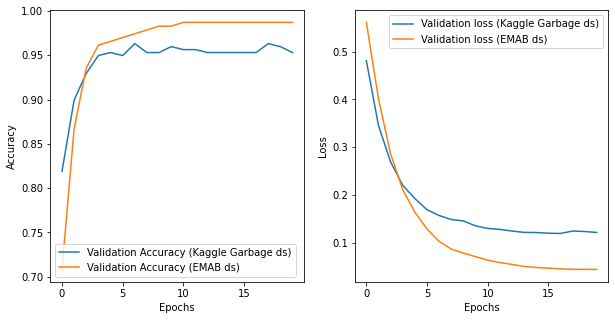

In [22]:
#@title Resultados del entrenamiento (Datos de entrenamiento)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(results.history['val_accuracy'], label='Validation Accuracy (Kaggle Garbage ds)');
ax.plot(results2.history['val_accuracy'], label='Validation Accuracy (EMAB ds)');
ax.set_xlabel('Epochs');
ax.set_ylabel('Accuracy');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(results.history['val_loss'], label='Validation loss (Kaggle Garbage ds)');
ax.plot(results2.history['val_loss'], label='Validation loss (EMAB ds)');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

## Observaciones
- Se puede apreciar que se obtiene por muy poco un mejor accuracy y valores de perdida en la etapa en el modelo entrenado con el dataset de la EMAB que en el dataset proveniente de Kaggle; Se intuye que esta pequeña diferencia en los resultados se es debido a que la red entrenada con las imagenes del dataset de la EMAB puede abstraer mejor la información especifica para la caracterización necesaria para interpretar si una imagen contiene acumulación de residuos contaminantes o no. A diferencia del otro dataset, en donde podemos encontrar algunas imagenes que aunque si se encuentran relacionadas con la tematica, estas poseen caracteristicas que pueden confundir la red debido a los cambios abruptos que presenta en su distribución en relación a las otras imagenes del dataset. Apesar de lo anterior, las pruebas con los dos datasets han logrado mostrar unos resultados interesantes.
- Apesar de que el ultimo modelo haya sido entrenado y validado con una cantidad desproporcionada de imagenes entre sus categorias (403 gb y 759 no_gb) que debería sugerir una tendencia en el modelo a predecir las imagenes con la etiqueta de no_gb con mayor probabilidad, esto no sucedio.

(8, 299, 299, 3)
[[5.4782575e-01 4.5217425e-01]
 [3.7834778e-01 6.2165225e-01]
 [9.3420511e-01 6.5794885e-02]
 [9.5086282e-01 4.9137186e-02]
 [3.6106389e-02 9.6389359e-01]
 [6.3532771e-04 9.9936467e-01]
 [2.3007483e-04 9.9976999e-01]
 [1.6865071e-02 9.8313498e-01]]
(8, 2) [0 1 0 0 1 1 1 1]


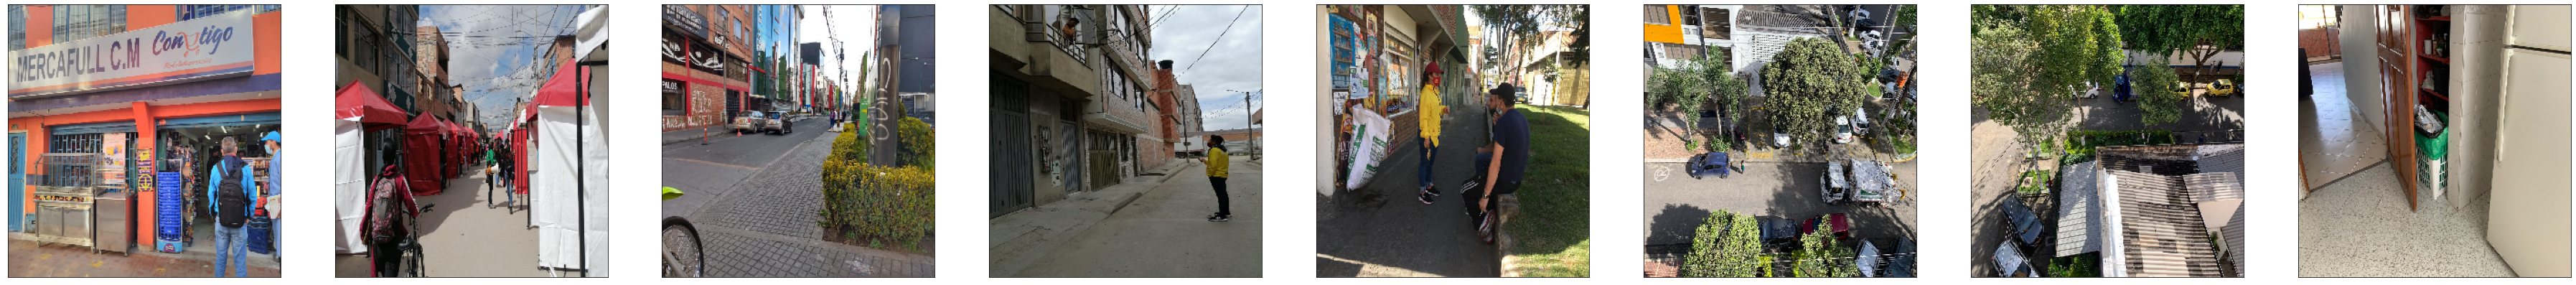

In [36]:
#@title Predicciones modelo entrenado con dataset Kaggle
test = []
process1 = tf.keras.preprocessing.image.load_img("Test (1).jpeg", target_size=(299, 299))
process2 = tf.keras.preprocessing.image.load_img("Test (2).jpeg", target_size=(299, 299))
process3 = tf.keras.preprocessing.image.load_img("Test (3).jpeg", target_size=(299, 299))
process4 = tf.keras.preprocessing.image.load_img("Test (4).jpeg", target_size=(299, 299))
process5 = tf.keras.preprocessing.image.load_img("Test (5).jpeg", target_size=(299, 299))
process6 = tf.keras.preprocessing.image.load_img("Test (6).jpeg", target_size=(299, 299))
process7 = tf.keras.preprocessing.image.load_img("Test (7).jpeg", target_size=(299, 299))
process8 = tf.keras.preprocessing.image.load_img("Test (8).jpeg", target_size=(299, 299))
test.append(tf.keras.preprocessing.image.img_to_array(process1));
test.append(tf.keras.preprocessing.image.img_to_array(process2));
test.append(tf.keras.preprocessing.image.img_to_array(process3));
test.append(tf.keras.preprocessing.image.img_to_array(process4));
test.append(tf.keras.preprocessing.image.img_to_array(process5));
test.append(tf.keras.preprocessing.image.img_to_array(process6));
test.append(tf.keras.preprocessing.image.img_to_array(process7));
test.append(tf.keras.preprocessing.image.img_to_array(process8));

trash = np.array(test)
trash = trash.astype('float32')
trash /= 255

print(trash.shape)
predictions = model.predict(trash)
fig = plt.figure(figsize=(64,64))
for i in range(8):
  ax = fig.add_subplot(1, 8, i+1)
  plot_image(i, predictions, np.argmax(y_test ,axis=1), test)
print(predictions)
print(predictions.shape, np.argmax(predictions, axis=1))

(8, 299, 299, 3)
[[2.7334026e-01 7.2665972e-01]
 [4.0201426e-01 5.9798580e-01]
 [1.3029842e-01 8.6970156e-01]
 [7.4058205e-01 2.5941795e-01]
 [2.7929859e-03 9.9720699e-01]
 [3.0757712e-06 9.9999690e-01]
 [5.3511121e-06 9.9999464e-01]
 [5.3171530e-02 9.4682848e-01]]
(8, 2) [1 1 1 0 1 1 1 1]


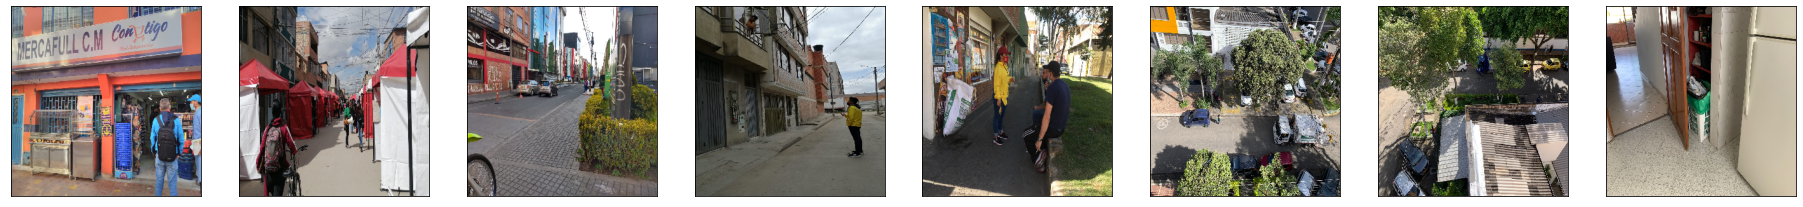

In [34]:
#@title Predicciones modelo entrenado con dataset EMAB
test = []
process1 = tf.keras.preprocessing.image.load_img("Test (1).jpeg", target_size=(299, 299))
process2 = tf.keras.preprocessing.image.load_img("Test (2).jpeg", target_size=(299, 299))
process3 = tf.keras.preprocessing.image.load_img("Test (3).jpeg", target_size=(299, 299))
process4 = tf.keras.preprocessing.image.load_img("Test (4).jpeg", target_size=(299, 299))
process5 = tf.keras.preprocessing.image.load_img("Test (5).jpeg", target_size=(299, 299))
process6 = tf.keras.preprocessing.image.load_img("Test (6).jpeg", target_size=(299, 299))
process7 = tf.keras.preprocessing.image.load_img("Test (7).jpeg", target_size=(299, 299))
process8 = tf.keras.preprocessing.image.load_img("Test (8).jpeg", target_size=(299, 299))
test.append(tf.keras.preprocessing.image.img_to_array(process1));
test.append(tf.keras.preprocessing.image.img_to_array(process2));
test.append(tf.keras.preprocessing.image.img_to_array(process3));
test.append(tf.keras.preprocessing.image.img_to_array(process4));
test.append(tf.keras.preprocessing.image.img_to_array(process5));
test.append(tf.keras.preprocessing.image.img_to_array(process6));
test.append(tf.keras.preprocessing.image.img_to_array(process7));
test.append(tf.keras.preprocessing.image.img_to_array(process8));

trash = np.array(test)
trash = trash.astype('float32')
trash /= 255

print(trash.shape)
predictions = model2.predict(trash)
fig = plt.figure(figsize=(32,32))
for i in range(8):
  ax = fig.add_subplot(1, 8, i+1)
  plot_image(i, predictions, np.argmax(y_test ,axis=1), test)
print(predictions)
print(predictions.shape, np.argmax(predictions, axis=1))